# Challenge 5

* We measure a spectrum of 10 guassian-distributed variables (`x`), indexed by an energy variable `E`.

* Signal and background are distributed differently in every bin:

    * `b(E)` is constant and equal to `B=60`.
    * `s(E)` follows a gaussian distribution: `s(E) = S*exp((E-E_0) / 2 \sigma_E^2)` with `E_0=4` and `\sigma_E=1`.
    * `S` is unknown and we want to estimate it from the data.
    

E =  [0.5 1.5 2.5 3.5 4.5 5.5 6.5 7.5 8.5 9.5]
x =  [62 69 74 86 69 81 68 54 66 71]


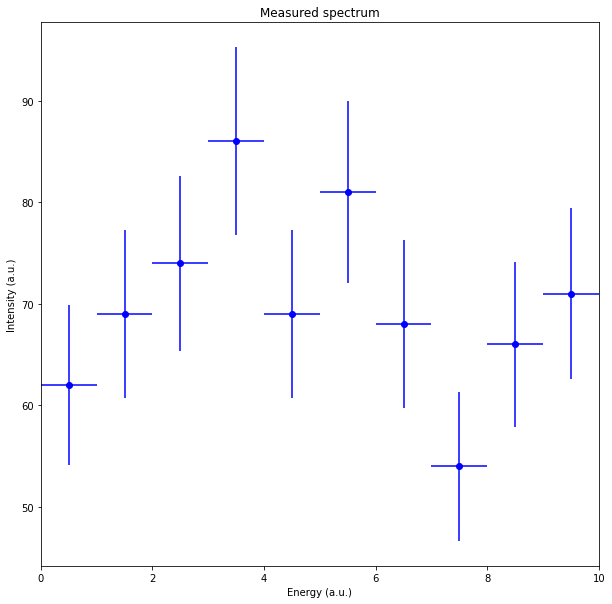

In [1]:
import sys

import matplotlib.pyplot as plt
import numpy as np
from numba import jit

np.random.seed(
    0
)  # We manually set the seed for reproducible results, this is not required

E = np.arange(0, 10) + 0.5
print("E = ", E)

intensity_data = np.array([62, 69, 74, 86, 69, 81, 68, 54, 66, 71])
print("x = ", intensity_data)

fig, ax = plt.subplots(figsize=(10, 10))

ax.set_xlim([0, 10])

ax.set_xlabel("Energy (a.u.)")
ax.set_ylabel("Intensity (a.u.)")
ax.set_title("Measured spectrum")

ax.errorbar(
    E, intensity_data, xerr=0.5, fmt="o", yerr=np.sqrt(intensity_data), color="blue"
)

plt.show()

In [2]:
@jit
def fit_func(E, S, E_0=4, sigma_E=1, B=60):
    return B + S * np.exp(-((E - E_0) ** 2) / (2 * sigma_E ** 2))

In [3]:
@jit
def chi2_estimator(y, f, sigma):
    result = 0
    for i in range(len(y)):
        result += ((y[i] - f[i]) ** 2) / (sigma[i] ** 2)
    return result

We compute the fit function for different values of S to compare the chi2 estimator

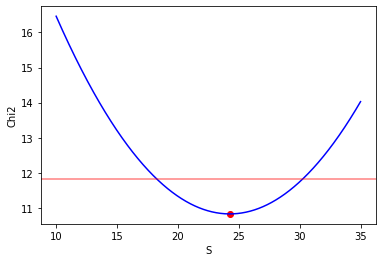

S = 24.264264264264263
S 68% CI: [18.26, 30.27]


In [4]:
S_values = []
chi2_values = []

chi2_min = 1e10
S_result = 0

S_range = np.linspace(10, 35, 1000)
for S in S_range:
    y = intensity_data
    sigma = np.sqrt(y) * 0 + 8
    f = np.array([fit_func(energy, S=S) for energy in E])
    chi2 = chi2_estimator(y, f, sigma)

    S_values.append(S)
    chi2_values.append(chi2)

    if chi2 < chi2_min:
        chi2_min = chi2
        S_result = S

plt.plot(S_values, chi2_values, color="blue")
plt.scatter([S_result], [chi2_min], color="red")

plt.xlabel("S")
plt.ylabel("Chi2")

plt.axhline(chi2_min + 1, color="red", alpha=0.5)

# find the intersection points

intersection_left = 0
intersection_right = 0

for i, S in enumerate(S_values):
    if S <= S_result:
        if intersection_left == 0 and chi2_values[i] <= chi2_min + 1:
            intersection_left = S
    else:
        if intersection_right == 0 and chi2_values[i] >= chi2_min + 1:
            intersection_right = S


plt.show()

print(f"S = {S_result}")
print(f"S 68% CI: [{intersection_left:0.2f}, {intersection_right:0.2f}]")

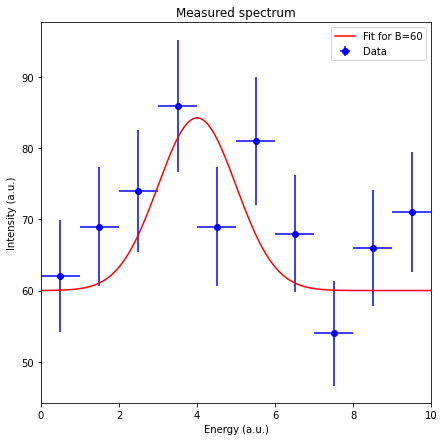

In [5]:
fig, ax = plt.subplots(figsize=(7, 7))

ax.set_xlim([0, 10])

ax.set_xlabel("Energy (a.u.)")
ax.set_ylabel("Intensity (a.u.)")
ax.set_title("Measured spectrum")

ax.errorbar(
    E,
    intensity_data,
    xerr=0.5,
    fmt="o",
    yerr=np.sqrt(intensity_data),
    color="blue",
    label="Data",
)

E_plt = np.linspace(0, 10, 1000)
ax.plot(E_plt, fit_func(E_plt, S=S_result), color="red", label="Fit for B=60")

plt.legend()
plt.show()

### Goodness of fit for B=60

We have 10 data points and one free parameter (S), so the number of degrees of freedom of the chi2 is 9

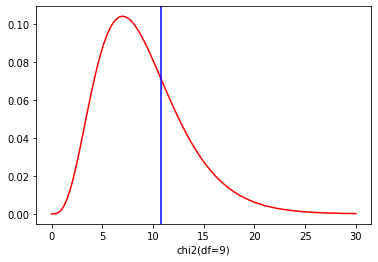

p-value = 0.29


In [6]:
from scipy.stats import chi2

x = np.linspace(0, 30, 100)
y = chi2(df=9).pdf(x)

plt.xlabel("chi2(df=9)")
plt.plot(x, y, color="red")
plt.axvline(x=chi2_min, color="blue")
plt.show()

print(f"p-value = {1 - chi2(df=9).cdf(chi2_min):0.2f}")

## Verify Chi2_min follows a Chi2 distribution

We do a MC simulation for 10000 samples

In [7]:
from scipy.stats import norm

number_of_samples = 10000

B = 60
E_0 = 4

S = 24.26

sigma = 8


@jit
def find_chi2_min(sample):
    chi2_min = 1e10
    S_min = 0

    for S_it in np.linspace(5, 50, 200):
        f = np.array([fit_func(energy, S=S_it, B=B, E_0=E_0) for energy in E])
        chi2 = chi2_estimator(sample, f, np.ones(len(y)) * sigma)
        if chi2 < chi2_min:
            chi2_min = chi2
            S_min = S_it

    return chi2_min, S_min


chi2min_list = []
Smin_list = []

for i in range(number_of_samples):
    if i % int(number_of_samples / 10) == 0:
        print(str(i / number_of_samples * 100) + "%")
        sys.stdout.flush()  # to avoid warning due to numba

    sample = np.array(
        [
            norm.rvs(size=1, loc=fit_func(energy, S=S, B=B, E_0=E_0), scale=sigma)[0]
            for energy in E
        ]
    )

    chi2min, Smin = find_chi2_min(sample)
    chi2min_list.append(chi2min)
    Smin_list.append(Smin)

0.0%
10.0%
20.0%
30.0%
40.0%
50.0%
60.0%
70.0%
80.0%
90.0%


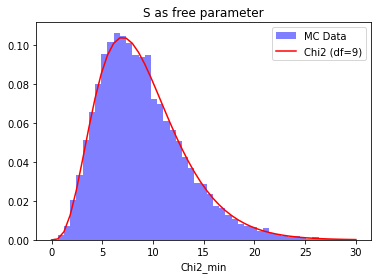

In [8]:
bins = np.linspace(0, 30, 50)
plt.hist(
    chi2min_list, bins=bins, density=True, label="MC Data", alpha=0.5, color="blue"
)

from scipy.stats import chi2

plt.plot(bins, chi2(df=10 - 1).pdf(bins), label="Chi2 (df=9)", color="red")

plt.legend()
plt.title("S as free parameter")
plt.xlabel("Chi2_min")
plt.show()

### Now with S and B as free parameters

S=15.51, B=65.51


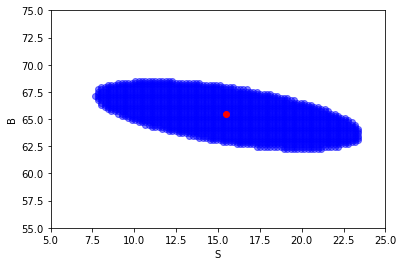

In [9]:
N = 100
S_range = np.linspace(5, 25, N)
B_range = np.linspace(55, 75, N)
chi2_values = np.zeros([N, N])
for i, S in enumerate(S_range):
    for j, B in enumerate(B_range):
        y = intensity_data
        sigma = np.sqrt(y)
        f = np.array([fit_func(energy, S=S, B=B) for energy in E])
        chi2_values[i, j] = chi2_estimator(y, f, sigma)

# find the position of the min
chi2_min = np.min(chi2_values)
S_index, B_index = np.unravel_index(
    np.argmin(chi2_values, axis=None), chi2_values.shape
)
S_result = S_range[S_index]
B_result = B_range[B_index]

print(f"S={S_result:0.2f}, B={B_result:0.2f}")

# CI

indices_inside_CI = []
for i, S in enumerate(S_range):
    for j, B in enumerate(B_range):
        if chi2_values[i, j] <= chi2_min + 1:
            indices_inside_CI.append((i, j))

S_CI = np.zeros(len(indices_inside_CI))
B_CI = np.zeros(len(indices_inside_CI))
for i, indices in enumerate(indices_inside_CI):
    S_CI[i] = S_range[indices[0]]
    B_CI[i] = B_range[indices[1]]

plt.scatter(S_CI, B_CI, color="blue", alpha=0.5)
plt.scatter([S_result], [B_result], color="red")

plt.xlim([min(S_range), max(S_range)])
plt.ylim([min(B_range), max(B_range)])

plt.xlabel("S")
plt.ylabel("B")

plt.show()

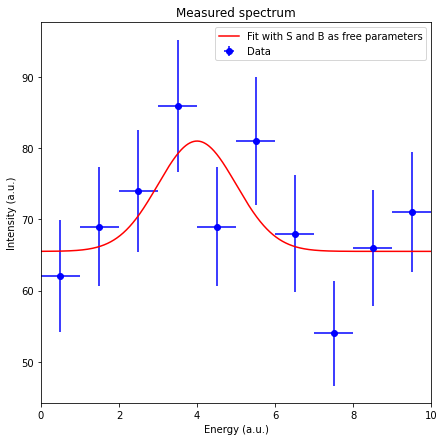

In [10]:
fig, ax = plt.subplots(figsize=(7, 7))

ax.set_xlim([0, 10])

ax.set_xlabel("Energy (a.u.)")
ax.set_ylabel("Intensity (a.u.)")
ax.set_title("Measured spectrum")

ax.errorbar(
    E,
    intensity_data,
    xerr=0.5,
    fmt="o",
    yerr=np.sqrt(intensity_data),
    color="blue",
    label="Data",
)

E_plt = np.linspace(0, 10, 1000)
ax.plot(
    E_plt,
    fit_func(E_plt, S=S_result, B=B_result),
    color="red",
    label="Fit with S and B as free parameters",
)

plt.legend()
plt.show()

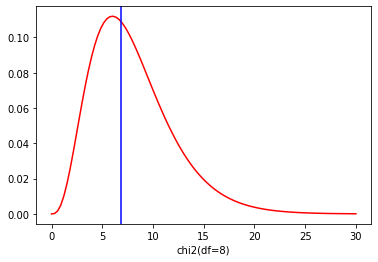

p-value = 0.56


In [11]:
from scipy.stats import chi2

x = np.linspace(0, 30, 100)
y = chi2(df=8).pdf(x)

plt.xlabel("chi2(df=8)")
plt.plot(x, y, color="red")
plt.axvline(x=chi2_min, color="blue")
plt.show()

print(f"p-value = {1 - chi2(df=8).cdf(chi2_min):0.2f}")

## Verify Chi2_min follows a Chi2 distribution

This may take a while, you are free to tune the parameters to make it faster. The most important parameter is `number_of_samples`.

In [12]:
from scipy.stats import norm

number_of_samples = 10000

E_0 = 4

S = 15.61
B = 65.39

sigma = 8


@jit
def find_chi2_min(sample):
    chi2_min = 1e10

    for S_it in np.linspace(10, 30, 100):
        for B_it in np.linspace(55, 75, 100):
            f = [fit_func(energy, S=S_it, B=B_it, E_0=E_0) for energy in E]
            chi2 = chi2_estimator(sample, f, np.ones(len(y)) * sigma)
            if chi2 < chi2_min:
                chi2_min = chi2
                S_min = S_it

    return chi2_min


chi2min_list = []

for i in range(number_of_samples):
    if i % int(number_of_samples / 10) == 0:
        print(str(i / number_of_samples * 100) + "%")
        sys.stdout.flush()  # to avoid warning due to numba

    sample = np.array(
        [
            norm.rvs(size=1, loc=fit_func(energy, S=S, B=B, E_0=E_0), scale=sigma)[0]
            for energy in E
        ]
    )

    chi2min = find_chi2_min(sample)
    chi2min_list.append(chi2min)

0.0%
10.0%
20.0%
30.0%
40.0%
50.0%
60.0%
70.0%
80.0%
90.0%


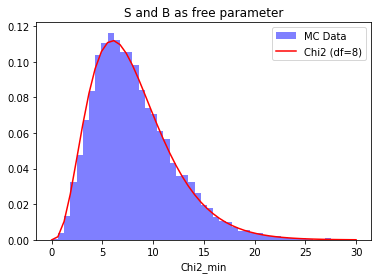

In [13]:
bins = np.linspace(0, 30, 50)
plt.hist(
    chi2min_list, bins=bins, density=True, label="MC Data", alpha=0.5, color="blue"
)

from scipy.stats import chi2

plt.plot(bins, chi2(df=10 - 2).pdf(bins), label="Chi2 (df=8)", color="red")

plt.legend()
plt.title("S and B as free parameter")
plt.xlabel("Chi2_min")
plt.show()